In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from _do_calculation import solve_mbes_general, solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_obes
from _mbes import mbes, mbes_soc, mbes_soc_no_cavity, mbes_soc_det, obes_soc
import matplotlib
# matplotlib.use('NbAgg')
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy.special import erf
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown, HTML
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io
import gc
from qutip import Bloch
from matplotlib.animation import FuncAnimation
import datetime
import time
import random
import matplotlib
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
from importlib import reload
import _spin_params as spin_pars
# matplotlib.pyplot.switch_backend('nbagg')
# %qtconsole

In [2]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins  # 701#5000#20
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

3.8622619793607544


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse


def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002) * \
        (1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse


def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    tend = np.pi/wgrund

    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004) * \
        (1-logistic.cdf(t, loc=tend-0.02, scale=0.004))

    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq

In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

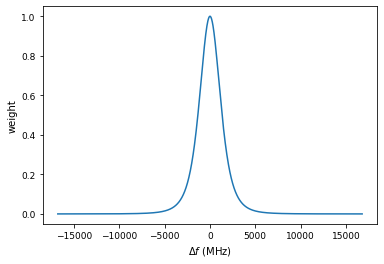

Cooperativity is: 0.598246


In [5]:
plt.close('all')
matplotlib.interactive(False)
spins, gs, pdf = create_spins_inhomo_g(
    gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
plt.show()
# %qtconsole
coop = gcoll**2/kappa*np.sum(pdf/(gperp+1j*2*np.pi*spins))
print("Cooperativity is: %f" % coop.real)

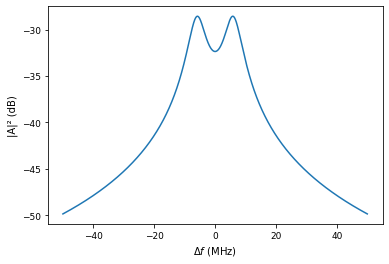

In [6]:
plt.close('all')
matplotlib.interactive(False)

initsteady = (0.001, 0.001)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)')
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
plt.show()
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [7]:
pumptime = 50e-3  # 5*np.pi/gcoll
decaytime = 1000e-3
dt = 0.0005
numsteps = int(pumptime/dt)
tlist = np.arange(0, pumptime+dt, dt)
tlistdecay = np.arange(0, decaytime+dt, dt)


# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0
# %qtconsole

### Calibrate power

In [8]:
pulsei = np.ones((len(tlist)))
pin = np.arange(-30,
                -10, 1)
aref = 2400

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(
        mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, :] = np.hstack((abs(asolpump[:, 0])**2, abs(asoldecay[:, 0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(
        np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 2::2]), np.real(asoldecay[:, 2::2])))
    small[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 1::2]), np.real(asoldecay[:, 1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(
        np.sum(asoldecay[:, 1::2], axis=1))))

-13


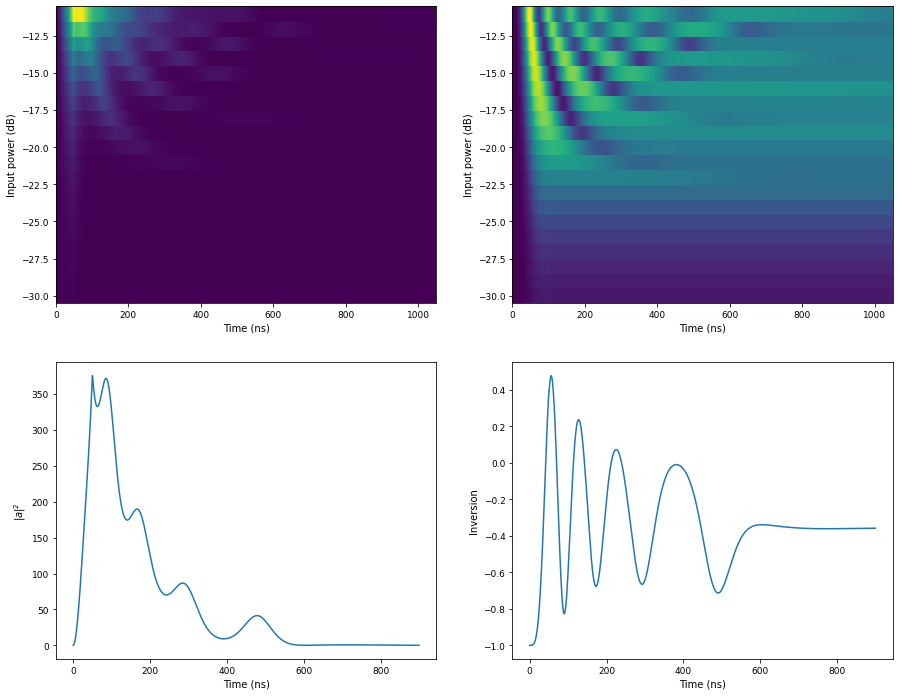

In [9]:
plt.close('all')
matplotlib.interactive(False)
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
ax1.pcolor(tplot, pin, alos, shading='auto')
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)')

ax2.pcolor(tplot, pin, szlos, shading='auto')
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)')
maxAmpl = abs(asolpump).max()

idxinv = 17
print(pin[idxinv])
ax3.plot(tplot[:-300], alos[idxinv, :-300])
#ax3.set_ylim([0, 1])
ax3.set_xlabel('Time (ns)')
ax3.set_ylabel('$|a|^2$')
ax4.plot(tplot[:-300], szlos[idxinv, :-300])
ax4.set_xlabel('Time (ns)')
ax4.set_ylabel('Inversion')
plt.show()
# %qtconsole

### OCT pulses

In [10]:
fcomps = np.array([-1.177,  1.646, -0.549, -1.668, -0.627,  0.151,  1.68, -0.024,
                   0.858,  1.311, -0.15, -0.355,  0.253,  1.165,  0.069,  0.47,
                   -0.649, -0.814,  0.643, -0.657])
tscale_pulse = 0.5
wgrund = 2*np.pi/tscale_pulse
nfreqs = int(len(fcomps)/2)

tp = np.arange(0, 0.504*tscale_pulse, dt)
dtf = 0.0005
tpf = np.arange(0, tp[-1]+dtf, dtf)
init = np.ones(nbins*2)*(-1)
init[::2] = 0


pulseif0 = pulse_rwa(tpf, (wgrund, fcomps[:nfreqs]))
pulseqf0 = pulse_rwa(tpf, (wgrund, fcomps[nfreqs:]))

pulsei0 = pulse_rwa(tp, (wgrund, fcomps[:nfreqs]))
pulseq0 = pulse_rwa(tp, (wgrund, fcomps[nfreqs:]))

obes_pulse_scaling = 4*np.pi/tscale_pulse
solpump_obes, infodict = solve_obes(obes_soc, init, pdf, tp, None, pulsei0 *
                                    obes_pulse_scaling, pulseq0 * obes_pulse_scaling, tp, 1, gperp, spins, gpar)

# this should be the perfect scaling for spins exactly at the center
# frequency. it is unfortunately impossible to make it correct for all the spins
amplitude_scaling = 1/gs[int(nbins/2)]/2*obes_pulse_scaling


ascalelist = np.linspace(0, 2, 101)*np.real(amplitude_scaling)
pulselist = np.zeros((len(ascalelist), 2, len(tp)))
solutionp = np.zeros(
    (len(ascalelist), len(tp), 2*nbins+1), dtype=np.complex128)
solutiond = np.zeros((len(ascalelist), len(tlistdecay),
                      2*nbins+1), dtype=np.complex128)


for j, ascale in enumerate(ascalelist):

    pulsei = pulsei0[:]*ascale
    pulseq = pulseq0[:]*ascale
    pulseif = pulsei0[:]*ascale
    pulseqf = pulseq0[:]*ascale

    solutionpump, infodict = solve_mbes_without_cavity(
        mbes_soc_no_cavity, init, pdf, tp, None, pulsei, pulseq, tp, deltac, gs, gperp, spins, gpar)
    print("Calculating %d from %d" % (j+1, len(ascalelist)), end="\r")
    ipulse, qpulse = get_pulses_from_cavity_field(
        pulsei + 1j*pulseq, pulseif+1j*pulseqf, solutionpump[:, ::2]/pdf, tp, tpf, kappa, deltac, gs)
    pulselist[j, 0, :] = ipulse
    pulselist[j, 1, :] = qpulse


init = np.ones(nbins*g_number*2+1)*(-1)
init[0] = 0
init[1::2] = 0
print("Finished calculating OCT pulses now checking performance")
for i, pulse in enumerate(pulselist):
    solutionpump2, soldecay, infodict = solve_mbes(
        mbes_soc, init, pdf, tp, tlistdecay, pulse[0], pulse[1], tp, kappa, deltac, gs, gperp, spins, gpar)
    print("Checking performance %d from %d" % (i+1, len(pulselist)), end="\r")
    solutionp[i, :, :] = solutionpump2
    solutiond[i, :, :] = soldecay

# solution = np.hstack((solutionp, solutiond))

Finished calculating OCT pulses now checking performance


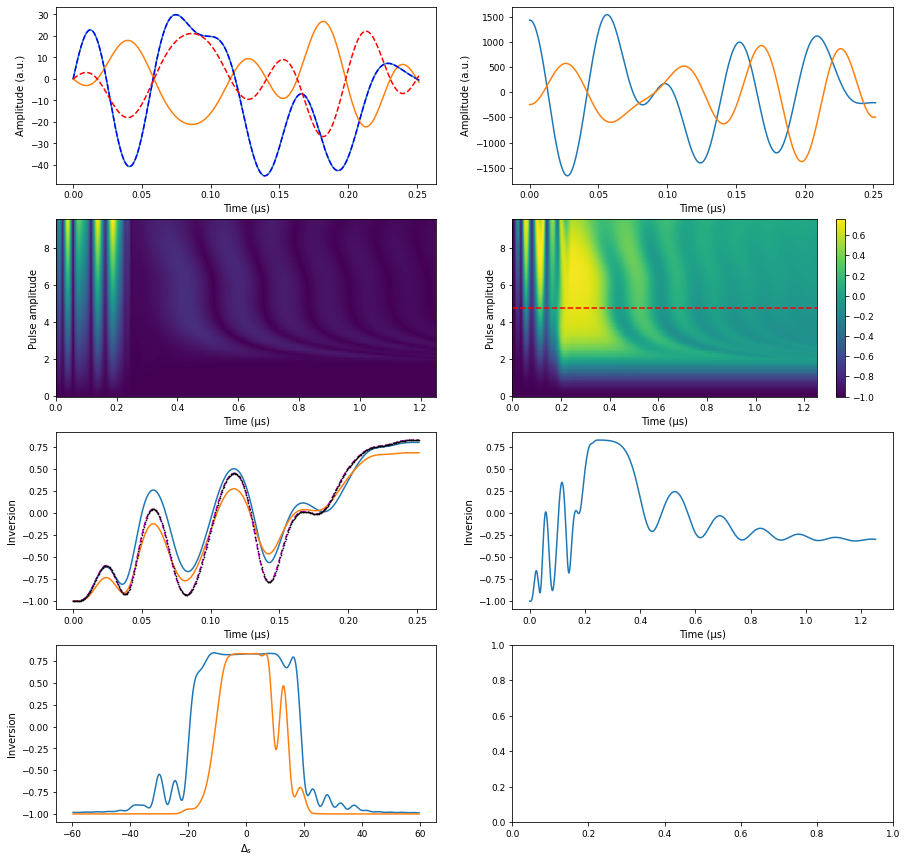

In [11]:
idealidx = 50
plt.close('all')
matplotlib.interactive(False)
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)
      ) = plt.subplots(4, 2, figsize=(15, 15))

ax0.plot(tpf, pulseif)
ax0.plot(tpf, pulseqf)

maxpf = max(max(abs(pulseif)), max(abs(pulseqf)))
maxps = max(max(abs(solutionp[idealidx, :, 0].real)),
            max(abs(solutionp[idealidx, :, 0].imag)))

ax0.plot(tp, solutionp[idealidx, :, 0].real/maxps*maxpf, 'b--')
ax0.plot(tp, solutionp[idealidx, :, 0].imag/maxps*maxpf, 'r--')
ax0.set_xlabel("Time (µs)")
ax0.set_ylabel("Amplitude (a.u.)")

ax1.plot(tp, pulselist[idealidx][0])
ax1.plot(tp, pulselist[idealidx][1])
#ax1.plot(tp, (pulselist[idealidx][0]**2+pulselist[idealidx][1]**2)**0.5)
ax1.set_xlabel("Time (µs)")
ax1.set_ylabel("Amplitude (a.u.)")

tall = np.linspace(0, tp[-1]+tlistdecay[-1],
                   len(solutiond[0])+len(solutionp[0]))

ax2.pcolor(tall, ascalelist, np.hstack(
    (abs(solutionp[:, :, 0]), abs(solutiond[:, :, 0]))), shading='auto')
c = ax3.pcolor(tall, ascalelist, np.hstack((np.sum(solutionp[:, :, 2::2], axis=2).real, np.sum(
    solutiond[:, :, 2::2], axis=2).real)), shading='auto')
fig.colorbar(c, ax=ax3)
ax3.plot([tall[0], tall[-1]], [ascalelist[idealidx], ascalelist[idealidx]], 'r--')
ax3.set_ylabel("Pulse amplitude")
ax2.set_ylabel("Pulse amplitude")
ax2.set_xlabel("Time (µs)")
ax3.set_xlabel("Time (µs)")

middleidx = int(nbins/2)
idxm = 50

d = (solpump_obes[:, 1::2]).real
d2 = (solutionp[idealidx, :, 2::2]).real

ax4.plot(tp, np.sum(d, axis=1))
ax4.plot(tp, np.sum(d2, axis=1))
ax4.plot(tp, d[:, int(nbins/2)]/pdf[int(nbins/2)], 'm--')
ax4.plot(tp, d2[:, int(nbins/2)]/pdf[int(nbins/2)], 'ko', markersize=0.6)
ax4.set_xlabel("Time (µs)")
ax4.set_ylabel("Inversion")

#ax5.plot(tp, solutionpump2[:, 0].real)
#ax5.plot(tp, solutionpump2[:, 0].imag)
#ax5.plot(tp, abs(solutionpump2[:, 0]))
#ax5.plot(tlistdecay+tp[-1], abs(soldecay[:,0]))

solutionideal = np.vstack((solutionp[idealidx], solutiond[idealidx]))


ax5.plot(tall, np.sum(solutionideal[:, 2::2][:, int(
    nbins/2)-idxm:int(nbins/2)+idxm]/pdf[int(nbins/2)-idxm:int(nbins/2)+idxm]/idxm/2, axis=1).real)
ax5.set_xlabel("Time (µs)")
ax5.set_ylabel("Inversion")
solmiddle = sol2 = np.sum(solutionideal[:, 2::2][:, int(
    nbins/2)-idxm:int(nbins/2)+idxm]/pdf[int(nbins/2)-idxm:int(nbins/2)+idxm], axis=1).real
tidx = 110
initjump = solutionideal[tidx, :]


ax6.plot(spins, d[-1, :]/pdf)
ax6.plot(spins, d2[-1, :]/pdf)
ax6.set_xlabel('$\Delta_s$')
ax6.set_ylabel('Inversion')

plt.show()

In [12]:
ipulse = pulselist[idealidx][0].copy()
qpulse = pulselist[idealidx][1].copy()

maxp = max(max(abs(ipulse)), max(abs(qpulse)))
ipulse *= 1/maxp
qpulse *= 1/maxp
pin_oct = np.arange(-30, 0, 1)


init = np.ones(nbins*g_number*2+1)*(-1)
init[0] = 0
init[1::2] = 0
solutionp_oct = np.zeros(
    (len(pin_oct), len(tp), 2*nbins+1), dtype=np.complex128)
solutiond_oct = np.zeros(
    (len(pin_oct), len(tlistdecay), 2*nbins+1), dtype=np.complex128)

for ctr, p in enumerate(pin_oct):
    print("Checking power %d from %d" % (ctr+1, len(pin_oct)), end="\r")
    dr = aref*10**(p/20.)
    solutionpump2, soldecay, infodict = solve_mbes(
        mbes_soc, init, pdf, tp, tlistdecay, ipulse*dr, qpulse*dr, tp, kappa, deltac, gs, gperp, spins, gpar)
    solutionp_oct[ctr, :, :] = solutionpump2
    solutiond_oct[ctr, :, :] = soldecay

-3


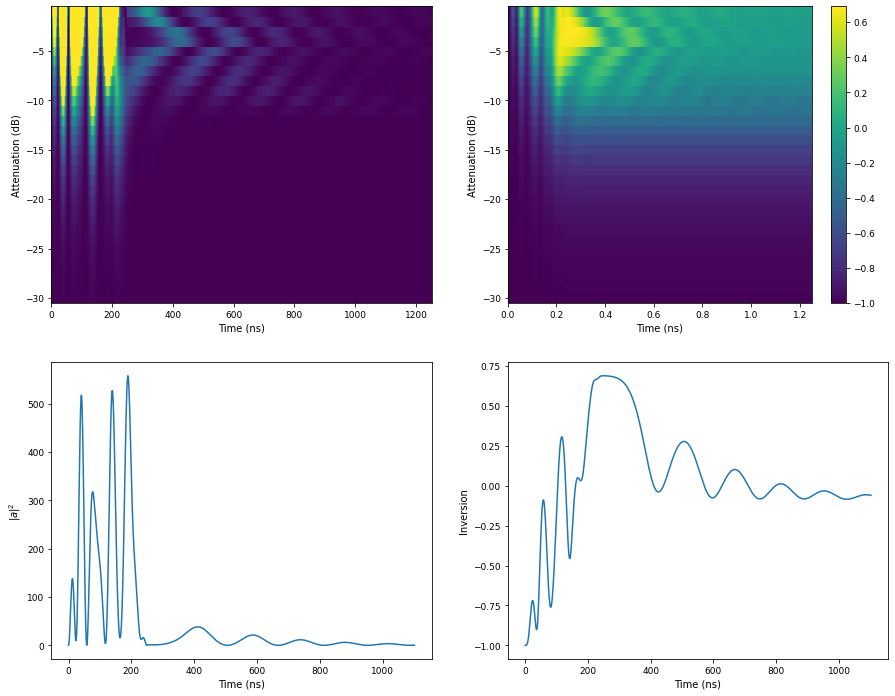

In [13]:
plt.close('all')
matplotlib.interactive(False)
szlos_oct = np.hstack((np.real(np.sum(solutionp_oct[:, :, 2::2], axis=2)), np.real(
    np.sum(solutiond_oct[:, :, 2::2], axis=2))))
smlos_oct = np.hstack(((np.sum(solutionp_oct[:, :, 1::2], axis=2)),
                       np.sum(solutiond_oct[:, :, 1::2], axis=2)))
alos_oct = np.hstack(
    (abs(solutionp_oct[:, :, 0])**2, abs(solutiond_oct[:, :, 0])**2))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
ax1.pcolor(tall*1000, pin_oct, alos_oct, shading='auto', vmax=100)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Attenuation (dB)')

c = ax2.pcolor(tall, pin_oct, szlos_oct, shading='auto')
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Attenuation (dB)')
fig.colorbar(c, ax=ax2)
maxAmpl = abs(asolpump).max()

idxpower = -3
print(pin_oct[idxpower])
ax3.plot(tall[:-300]*1000, alos_oct[idxpower, :-300])
ax3.set_xlabel('Time (ns)')
ax3.set_ylabel('$|a|^2$')
#ax3.set_ylim([0, 100])
ax4.plot(tall[:-300]*1000, szlos_oct[idxpower, :-300])
ax4.set_xlabel('Time (ns)')
ax4.set_ylabel('Inversion')
plt.show()

# saving pulse on measurement folder
saving_pulse = False
pulse = np.vstack((ipulse, qpulse))
if saving_pulse:
    strtime = datetime.datetime.strftime(
        datetime.datetime.now(), '%Y-%m-%d_%H:%M:%S')
    scipy.io.savemat('%soct_pulse_%s' %
                     (spin_params.folder, strtime), {'pulse': pulse})

In [14]:
%matplotlib widget
plt.close('all')
matplotlib.interactive(False)


szlos_oct_animate = (solutionp_oct[:, :, 2::2])/pdf
smlos_oct_animate = (solutionp_oct[:, :, 1::2])/pdf


def middle_out(a):
    while a:
        yield a.pop(len(a) // 2)


stepsize = 9
idxs = np.arange(int(nbins/2)-10*stepsize, int(nbins/2)+11*stepsize, stepsize)
spins_plot = spins[idxs]
idxs = np.asarray(list(middle_out(list(idxs))))[::-1]
cmap = cm.get_cmap("brg")
norm = matplotlib.colors.Normalize(vmin=min(spins_plot), vmax=max(spins_plot))
colors_idx = (spins[idxs]-min(spins[idxs]))/(max(spins[idxs])-min(spins[idxs]))
colors = cmap(colors_idx)

weights = pdf[idxs]
weights *= 1/max(weights)

sz_animate = szlos_oct_animate[idxpower, :, idxs].real
sx_animate = smlos_oct_animate[idxpower, :, idxs].real
sy_animate = smlos_oct_animate[idxpower, :, idxs].imag
lenframes = len(sz_animate[0, :])

vecs = np.zeros((*np.shape(sz_animate), 3))
vecs[:, :, 0] = sx_animate
vecs[:, :, 1] = sy_animate
vecs[:, :, 2] = sz_animate

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1, projection='3d')

cb1 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.7)
cb1.set_label('Detuning (MHz)')
b = Bloch(axes=ax)
b.fig = fig


def init():
    b.clear()
    b.zlabel = ['$\\left|1\\right>$', '$\\left|0\\right>$']
    b.font_size = 15
    b.vector_color = colors
    b.point_size = [1]
    b.point_color = [cmap(0.5)]
    return ax


def animate(frame_num):
    b.clear()
    b.add_vectors(vecs[:, frame_num, :])
    b.add_points([vecs[-1, :frame_num+1, 0], vecs[-1,
                 :frame_num+1, 1], vecs[-1, :frame_num+1, 2]])
    b.make_sphere()
    return ax


anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init,
                                          frames=lenframes, interval=1,
                                          blit=False, repeat=False)


del szlos_oct_animate, smlos_oct_animate
gc.collect()
plt.show()
%matplotlib inline

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Switching detuning quickly while pumping

In [15]:
init = np.ones(nbins*g_number*2+1)*(-1)
init[0] = 0
init[1::2] = 0

ilist = pulselist[idealidx][0]
qlist = pulselist[idealidx][1]

timeswitch = 4000e-3  # how long we are detuned
det_strength = -2*np.pi*20  # how far we are detuning the spins
timeafterswitch = 5000e-3
timeafterswitch_probe = 1000e-3
probetime = 20e-3

tall_switch = np.arange(0, len(ilist)*dt+timeswitch+timeafterswitch, dt)
ilist_p = np.hstack((ilist, np.zeros(len(tall_switch)-len(ilist))))
qlist_p = np.hstack((qlist, np.zeros(len(tall_switch)-len(ilist))))

idxprobe = int(timeswitch/dt+len(ilist)+timeafterswitch_probe/dt)
idxprobe2 = int(idxprobe+probetime/dt)
ilist_p[idxprobe:idxprobe2] = 1

dtswitch = 5e-3
tswi = np.arange(0, dtswitch, dt)

switch_on = 0.5*(1+np.tanh((tswi-dtswitch/2)/dtswitch*5))
switch_off = np.flip(switch_on)
delta_t_arr = np.ones(len(tall_switch))
delta_t_arr[:len(ilist)] = 0
delta_t_arr[len(ilist):(len(ilist)+len(tswi))] *= det_strength*switch_on
delta_t_arr[(len(ilist)+len(tswi)):] *= det_strength
delta_t_arr[-int(timeafterswitch/dt):(-int(timeafterswitch /
                                           dt)+len(tswi))] = det_strength*switch_off
delta_t_arr[(-int(timeafterswitch/dt)+len(tswi)):] = 0
# 1/2*(1+tanh(a*t))a

# %qtconsole


solution_switch,  infodict = solve_mbes_general(
    mbes_soc_det, init, pdf, tall_switch, ilist_p, qlist_p, delta_t_arr, tall_switch, kappa, deltac, gs, gperp, spins, gpar)